In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, precision_recall_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, average_precision_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.feature_selection import SelectFromModel, chi2, SelectKBest
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Importing models
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Function for printing ROC and f1 score
def print_results(ytest, ypred, ypredproba):
    roc = roc_auc_score(ytest, ypredproba[:,1], average='weighted')
    f1 = f1_score(ytest, ypred, average='weighted')
    print('[ Metrics Evaluation ]\n')
    print('ROC Auc:    {}'.format(roc))
    print('f1 Score:     {}'.format(f1))
    print(('Classification Report:\n{}'.format(classification_report(ytest, ypred))))
    return roc, f1

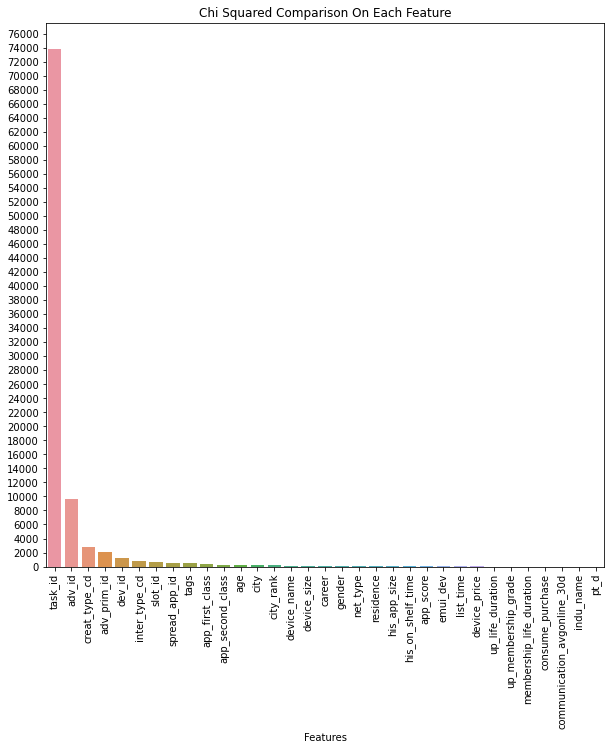

In [4]:
# Input all the features after filtering from pearsonr to x and y
# Read csv that has been sampled, clean data
df = pd.read_csv('ageGroup.csv')
df = df.drop('communication_onlinerate', axis=1) # Cannot infer from this feature
df = df.drop('uid', axis=1) # Cannot infer from this feature
df[df < 0] = 0 # Change all negative values to 0

x = df.drop(['label'], axis=1)
y = df["label"]
y = LabelEncoder().fit_transform(y)

# Split data into training and testing data, and make sure it is stratified (ratio maintained)
cv = StratifiedKFold(n_splits=5, shuffle=True)
for train_idx, test_idx in cv.split(x, y):
    x_train, y_train = x.iloc[train_idx], y[train_idx]
    x_test, y_test = x.iloc[test_idx], y[test_idx]

# Use Chi squared to select all the best features
select_feature = SelectKBest(chi2, k='all').fit(x_train, y_train)
x_train = pd.DataFrame(select_feature.transform(x_train), columns = x_train.columns[select_feature.get_support()])
x_test = pd.DataFrame(select_feature.transform(x_test), columns = x_test.columns[select_feature.get_support()])


# Use SMOTE for data oversampling
over = SMOTE()
x_train_oversample, y_train_oversample = over.fit_resample(x_train, y_train)  
x_test_oversample, y_test_oversample = over.fit_resample(x_test, y_test)

plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 80000, 2000))
plt.title('Chi Squared Comparison On Each Feature')
plt.xlabel('Features')
sns.barplot(x.columns, -np.sort(-select_feature.scores_))
# print(x.columns)
# print(select_feature.pvalues_ )

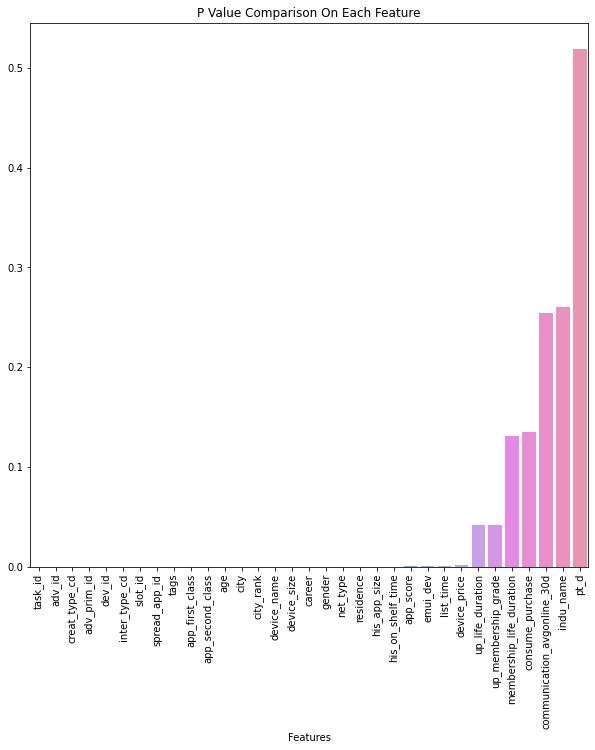

In [5]:
plt.figure(figsize=(10, 10))
plt.xticks(rotation=90)
plt.title('P Value Comparison On Each Feature')
plt.xlabel('Features')
sns.barplot(x.columns, np.sort(select_feature.pvalues_))

[66327   901  4427 62801]


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[ Metrics Evaluation ]

ROC Auc:    0.9825133016565638
f1 Score:     0.960346383715181
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     67228
           1       0.99      0.93      0.96     67228

    accuracy                           0.96    134456
   macro avg       0.96      0.96      0.96    134456
weighted avg       0.96      0.96      0.96    134456



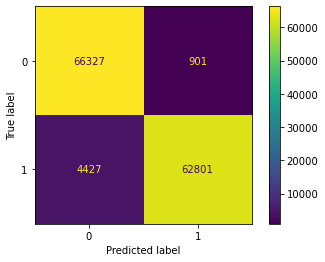

In [6]:
# LGBM
# Use LGBM Classifier and find the result of the prediction and prediction probability
# When both train and test data are oversampled
lgbm = LGBMClassifier(application='binary', max_depth=-10, metrics = 'auc').fit(x_train_oversample, y_train_oversample)
y_pred = lgbm.predict(x_test_oversample)
y_predproba = lgbm.predict_proba(x_test_oversample)

# Printing the metrics evaluation
# TN, FP, FN, TP
print(confusion_matrix(y_test_oversample, y_pred).ravel())
plot_confusion_matrix(lgbm, x_test_oversample, y_test_oversample)
roc_lgbm_over, f1_lgbm_over = print_results(y_test_oversample, y_pred, y_predproba)

[66327   901  2622   150]


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[ Metrics Evaluation ]

ROC Auc:    0.6350988448905239
f1 Score:     0.9386612468115946
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     67228
           1       0.14      0.05      0.08      2772

    accuracy                           0.95     70000
   macro avg       0.55      0.52      0.53     70000
weighted avg       0.93      0.95      0.94     70000



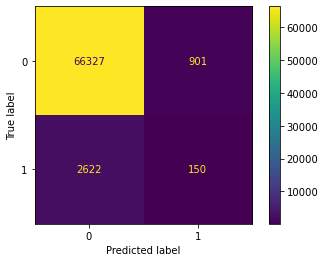

In [7]:
# LGBM
# When only train data is oversampled
lgbm = LGBMClassifier(application='binary', max_depth=-10, metrics = 'auc').fit(x_train_oversample, y_train_oversample)
y_pred = lgbm.predict(x_test)
y_predproba = lgbm.predict_proba(x_test)

# Printing the metrics evaluation
# TN, FP, FN, TP
print(confusion_matrix(y_test, y_pred).ravel())
plot_confusion_matrix(lgbm, x_test, y_test)
roc_lgbm, f1_lgbm = print_results(y_test, y_pred, y_predproba)

[18:20:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[66558   670  3665 63563]


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[ Metrics Evaluation ]

ROC Auc:    0.9840444187687042
f1 Score:     0.967742964401295
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     67228
           1       0.99      0.95      0.97     67228

    accuracy                           0.97    134456
   macro avg       0.97      0.97      0.97    134456
weighted avg       0.97      0.97      0.97    134456



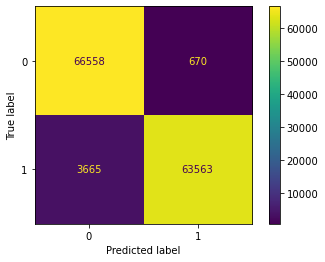

In [8]:
# XGBoost
# Use XGB Classifier and find the result of the prediction and prediction probability 
# When both train and test data are oversampled
xgb = XGBClassifier(max_depth=6, min_child_weight=2, use_label_encoder =False).fit(x_train_oversample, y_train_oversample)
y_pred = xgb.predict(x_test_oversample)
y_predproba = xgb.predict_proba(x_test_oversample)

# Printing the metrics evaluation
# TN, FP, FN, TP
print(confusion_matrix(y_test_oversample, y_pred).ravel())
plot_confusion_matrix(xgb, x_test_oversample, y_test_oversample)
roc_xgb_over, f1_xgb_over = print_results(y_test_oversample, y_pred, y_predproba)

[18:21:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[66558   670  2633   139]


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[ Metrics Evaluation ]

ROC Auc:    0.64527374581779
f1 Score:     0.9402208571441748
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     67228
           1       0.17      0.05      0.08      2772

    accuracy                           0.95     70000
   macro avg       0.57      0.52      0.53     70000
weighted avg       0.93      0.95      0.94     70000



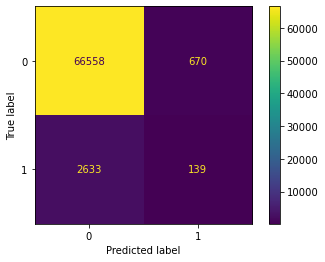

In [9]:
# XGBoost
# When only train data is oversampled
xgb = XGBClassifier(max_depth=6, min_child_weight=2, use_label_encoder =False).fit(x_train_oversample, y_train_oversample)
y_pred = xgb.predict(x_test)
y_predproba = xgb.predict_proba(x_test)

# Printing the metrics evaluation
# TN, FP, FN, TP
print(confusion_matrix(y_test, y_pred).ravel())
plot_confusion_matrix(xgb, x_test, y_test)
roc_xgb, f1_xgb = print_results(y_test, y_pred, y_predproba)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.3s finished
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[66634   594  9452 57776]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.7s finished


[ Metrics Evaluation ]

ROC Auc:    0.977427826119024
f1 Score:     0.9249584113830147
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     67228
           1       0.99      0.86      0.92     67228

    accuracy                           0.93    134456
   macro avg       0.93      0.93      0.92    134456
weighted avg       0.93      0.93      0.92    134456



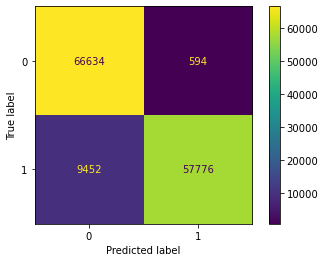

In [10]:
# Random Forest Classifier
# Use Random Forest Classifier and find the result of the prediction and prediction probability
# When both train and test data are oversampled
rfc = RandomForestClassifier(verbose=1, max_leaf_nodes=-15).fit(x_train_oversample, y_train_oversample)
y_pred = rfc.predict(x_test_oversample)
y_predproba = rfc.predict_proba(x_test_oversample)

# TN, FP, FN, TP
print(confusion_matrix(y_test_oversample, y_pred).ravel())
plot_confusion_matrix(rfc, x_test_oversample, y_test_oversample)
roc_rfc_over, f1_rfc_over = print_results(y_test_oversample, y_pred, y_predproba)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished
C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[66645   583  2673    99]


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.2s finished


[ Metrics Evaluation ]

ROC Auc:    0.6293751874369325
f1 Score:     0.9397688992515156
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     67228
           1       0.15      0.04      0.06      2772

    accuracy                           0.95     70000
   macro avg       0.55      0.51      0.52     70000
weighted avg       0.93      0.95      0.94     70000



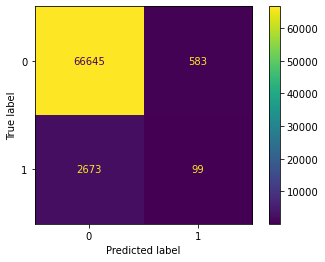

In [11]:
# Random Forest Classifier
# When only train data is oversampled
rfc = RandomForestClassifier(verbose=1, max_leaf_nodes=-15).fit(x_train_oversample, y_train_oversample)
y_pred = rfc.predict(x_test)
y_predproba = rfc.predict_proba(x_test)

# TN, FP, FN, TP
print(confusion_matrix(y_test, y_pred).ravel())
plot_confusion_matrix(rfc, x_test, y_test)
roc_rfc, f1_rfc = print_results(y_test, y_pred, y_predproba)

[62810  4418 11394 55834]


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[ Metrics Evaluation ]

ROC Auc:    0.897646709283014
f1 Score:     0.8820827736583939
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     67228
           1       0.93      0.83      0.88     67228

    accuracy                           0.88    134456
   macro avg       0.89      0.88      0.88    134456
weighted avg       0.89      0.88      0.88    134456



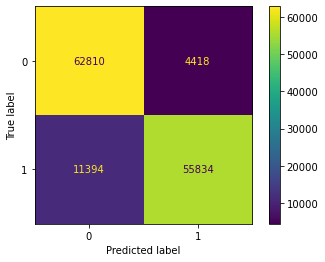

In [12]:
# Decision Tree Classifier
# Use Decision Tree Classifier and find the result of the prediction and prediction probability
# When both train and test data are oversampled
dtc =  DecisionTreeClassifier(max_depth=42, min_samples_split=10, criterion='entropy').fit(x_train_oversample, y_train_oversample)
y_pred = dtc.predict(x_test_oversample)
y_predproba = dtc.predict_proba(x_test_oversample)

# TN, FP, FN, TP
print(confusion_matrix(y_test_oversample, y_pred).ravel())
plot_confusion_matrix(dtc, x_test_oversample, y_test_oversample)
roc_dtc_over, f1_dtc_over = print_results(y_test_oversample, y_pred, y_predproba)

In [13]:
# dtc =  DecisionTreeClassifier(max_depth=42, min_samples_split=2, criterion='entropy').fit(x_train_oversample, y_train_oversample)
# param_grid = {
#     'max_features': ['auto', 'sqrt', 'log2']
# #     'min_samples_leaf': [x for x in range(-3, 3, 1)],    
# }
# grid = GridSearchCV(estimator=dtc, param_grid=param_grid)
# grid_result = grid.fit(x_train_oversample, y_train_oversample)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

[62821  4407  2450   322]


C:\Users\User\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


[ Metrics Evaluation ]

ROC Auc:    0.5325061681936794
f1 Score:     0.9140978855374146
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95     67228
           1       0.07      0.12      0.09      2772

    accuracy                           0.90     70000
   macro avg       0.52      0.53      0.52     70000
weighted avg       0.93      0.90      0.91     70000



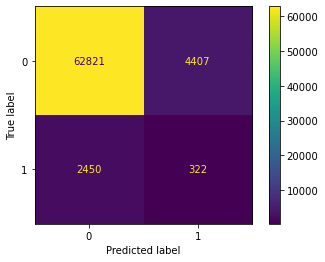

In [14]:
# Decision Tree Classifier
# When only train data is oversampled
dtc =  DecisionTreeClassifier(max_depth=42, min_samples_split=10, criterion='entropy').fit(x_train_oversample, y_train_oversample)
y_pred = dtc.predict(x_test)
y_predproba = dtc.predict_proba(x_test)

# TN, FP, FN, TP
print(confusion_matrix(y_test, y_pred).ravel())
plot_confusion_matrix(dtc, x_test, y_test)
roc_dtc, f1_dtc = print_results(y_test,y_pred, y_predproba)

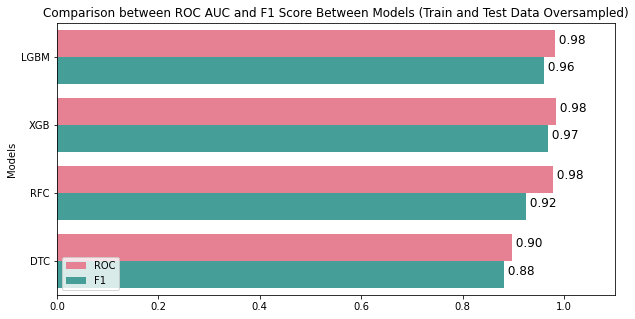

In [15]:
labelArr = np.array(['ROC', 'ROC', 'ROC', 'ROC', 'F1', 'F1', 'F1', 'F1'])
metricsArr = np.array([roc_lgbm_over, roc_xgb_over, roc_rfc_over, roc_dtc_over, f1_lgbm_over, f1_xgb_over, f1_rfc_over, f1_dtc_over])
xArr = np.array(['LGBM', 'XGB', 'RFC', 'DTC', 'LGBM', 'XGB', 'RFC', 'DTC'])

# Plot ROC and F1 from all models
plt.figure(figsize=(10, 5))
bar = sns.barplot(metricsArr, xArr, hue=labelArr, palette='husl')
plt.legend(loc='lower left')
bar.set(xlim = (None, 1.1))
bar.set_title('Comparison between ROC AUC and F1 Score Between Models (Train and Test Data Oversampled)')
bar.set_ylabel("Models")

# Put the exact value in the graph
for p in bar.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)

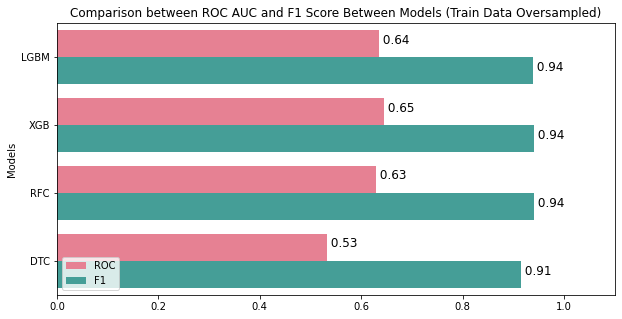

In [16]:
labelArr = np.array(['ROC', 'ROC', 'ROC', 'ROC', 'F1', 'F1', 'F1', 'F1'])
metricsArr = np.array([roc_lgbm, roc_xgb, roc_rfc, roc_dtc, f1_lgbm, f1_xgb, f1_rfc, f1_dtc])
xArr = np.array(['LGBM', 'XGB', 'RFC', 'DTC', 'LGBM', 'XGB', 'RFC', 'DTC'])

# Plot ROC and F1 from all models
plt.figure(figsize=(10, 5))
bar = sns.barplot(metricsArr, xArr, hue=labelArr, palette='husl')
plt.legend(loc='lower left')
bar.set(xlim = (None, 1.1))
bar.set_title('Comparison between ROC AUC and F1 Score Between Models (Train Data Oversampled)')
bar.set_ylabel("Models")

# Put the exact value in the graph
for p in bar.patches: 
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    bar.text(x+width, 
           y+height/2, 
           " %.2f"%width, 
           horizontalalignment="left",fontsize=12)